<a href="https://colab.research.google.com/github/iamviji/project/blob/master/PostMidTerm/Experiment/KerasQpskIncreasingInputSize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy
import time
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras import Model
from keras.layers.normalization import BatchNormalization


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

input_message_length = 2
encoder_output_length = 2
channel_size = 1
NUM_OF_INPUT_MESSAGE = 1000
SNR_STEP_SIZE = .5

SNR_BEGIN = 0
SNR_END = 10

bler_per_iter_uncoded_commpy_psk_2= [0.521, 0.473, 0.436, 0.37,  0.304, 0.259, 0.187, 0.138, 0.098, 0.098, 0.052, 0.028, 0.012, 0.011, 0.009, 0.002, 0.0,  0.001, 0.,    0.0]
bler_per_iter_uncoded_itpp_psk_2= [0.518, 0.478, 0.415, 0.355, 0.305, 0.227, 0.177, 0.149, 0.11,  0.075, 0.055, 0.023, 0.014, 0.014, 0.015, 0.001, 0.003, 0.001, 0.,    0. ]
bler_per_iter_uncoded_commpy_psk_4 = [0.815, 0.793, 0.75,  0.714, 0.64,  0.639, 0.526, 0.49,  0.433, 0.371, 0.335, 0.236, 0.204, 0.154, 0.129, 0.08,  0.063, 0.046, 0.023, 0.018]
bler_per_iter_uncoded_itpp_psk_4 = [0.814, 0.767, 0.729, 0.702, 0.66,  0.616, 0.563, 0.511, 0.442, 0.4,   0.294, 0.277, 0.228, 0.17,  0.114, 0.087, 0.05,  0.037, 0.022, 0.017]
bler_per_iter_ldpc_itpp_psk_4 = [0.584, 0.488, 0.404, 0.332, 0.218, 0.151, 0.097, 0.058, 0.041, 0.024, 0.007, 0.004, 0.002, 0.001, 0.001, 0.,    0.,    0.,    0.,    0.,   ]
bler_per_iter_ham_itpp_psk_4= [0.51, 0.479, 0.419, 0.333, 0.313, 0.247, 0.212, 0.132, 0.114, 0.093, 0.042, 0.027, 0.024, 0.016, 0.006, 0.005, 0.003, 0.002, 0.,    0.  ]


def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma


def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff


In [40]:

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


decoder_input_x = tf.placeholder("float32", [None, input_message_length], name="decoder_input_x")

snr_std = 7.0

input_message_x = Input(shape=(input_message_length,))
# "encoded" is the encoded representation of the input
enc_layer1 = Dense(encoder_output_length, activation='tanh')(input_message_x)
enc_layer2 = Dense(2*channel_size, activation='tanh')(enc_layer1)
enc_layer3 =  enc_layer2 / tf.sqrt(tf.reduce_mean(tf.square(enc_layer2)))
encoder = Model(input_message_x, enc_layer3)

awgn_channel = GaussianNoise(Snr2Sigma(snr_std),input_shape=(2*channel_size,))

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(2*channel_size,))
dec_layer1 = Dense(encoder_output_length, activation='tanh')(encoded_input)
dec_layer2 = Dense(input_message_length, activation='sigmoid')(dec_layer1)
# this model maps an encoded input to its decoder representation
decoder = Model(encoded_input, dec_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))

decoder_output = (tf.nn.sigmoid(decoder_input_x))

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "functional_185"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 2)            6           input_9[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 2)            6           dense_16[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Square_4 (TensorFlo multiple             0           dense_17[0][0]                   
_____________________________________________________________________________________

In [41]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))
print(input_message_length)

[[1 0]
 [1 1]
 [0 1]
 ...
 [1 1]
 [0 0]
 [1 0]]
10000
2


In [42]:
test_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (test_input_message)
print (len(test_input_message))

[[1 1]
 [0 0]
 [0 0]
 ...
 [0 1]
 [1 0]
 [0 0]]
10000


In [43]:
import keras

#def custom_losff_fucntion (act, pred):
#  return (tf.reduce_mean(-1*(act * tf.log(pred) + (1-act)*tf.log(1-pred))))

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
#autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion)
#loss='mean_squared_error'
#for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  snr_std = sigma
  print ("Training for SNR=", snr, " sigma=", sigma) 
  awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
  autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  opt = keras.optimizers.Adam(learning_rate=0.003)
  autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  autoencoder.fit(training_input_message, training_input_message,
                #epochs=50, original
                epochs=25,
                batch_size=500,
                shuffle=False,
                validation_data=(test_input_message, test_input_message))

Training for SNR= 0.0  sigma= 1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/25
10000/10000 [==============================] - 1s 137us/sample - loss: 0.6880 - val_loss: 0.6525
Epoch 2/25
10000/10000 [==============================] - 0s 8us/sample - loss: 0.6678 - val_loss: 0.6167
Epoch 3/25
10000/10000 [==============================] - 0s 8us/sample - loss: 0.6422 - val_loss: 0.5736
Epoch 4/25
10000/10000 [==============================] - 0s 8us/sample - loss: 0.6092 - val_loss: 0.5320
Epoch 5/25
10000/10000 [==============================] - 0s 8us/sample - loss: 0.5705 - val_loss: 0.4992
Epoch 6/25
10000/10000 [==============================] - 0s 8us/sample - loss: 0.5460 - val_loss: 0.4760
Epoch 7/25
10000/10000 [==============================] - 0s 9us/sample - loss: 0.5244 - val_loss: 0.4587
Epoch 8/25
10000/10000 [==============================] - 0s 9us/sample - loss: 0.5128 - val_loss: 0.4449
Epoch 9/25
10000/10000 [==============================] - 0s 8us/s

In [44]:

# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor_2  = numpy.array(())
times_per_iter_dl_tensor_2 = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(channel_size,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [channel_size])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

channel_in = []
channel_out = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    channel_in.append(encoded_message[0])
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print("encoded:",encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    #noised_message = commpy.channels.awgn(encoded_message, snr)
    noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,2*channel_size])
    channel_out.append(noised_message[0]) 
    #noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,channel_size])
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    #print ("decoded1:", decoded_message)
    #decoded_message = train_sess.run ([decoder_output], feed_dict={decoder_input_x:decoded_message})
    #print ("decoded2:", decoded_message)
    #decoded_message = autoencoder.predict(input_message_xx)
    decoded_message = numpy.around(decoded_message[0]).astype(int)
    #print ("decoded3:", decoded_message)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print ("decoded:", decoded_message)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor_2 = numpy.append(ber_per_iter_dl_tensor_2 ,ber)
  times_per_iter_dl_tensor_2 = numpy.append(times_per_iter_dl_tensor_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 7.08s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 8.27s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 9.53s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 10.71s
SNR: 0.000:
 -> BER: 0.31
 -> Total Time: 35.59s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.18s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.38s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.60s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.79s
SNR: 0.500:
 -> BER: 0.27
 -> Total Time: 11.95s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.19s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.46s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.69s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.89s
SNR: 1.000:
 -> BER: 0.25
 -> Total Time: 12.23s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.26s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 2.50s
SNR: 1.500 - Iter: 750 - Last 250.0 i

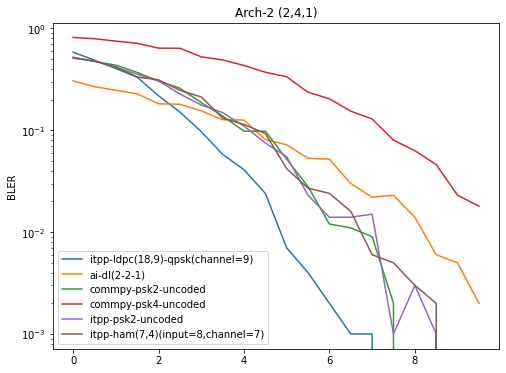

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_2,'', label="ai-dl(2-2-1)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

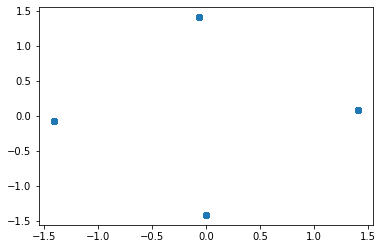

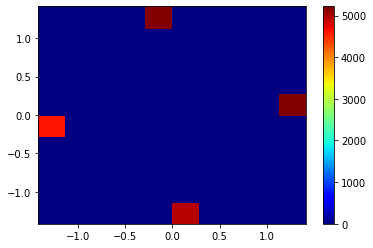

In [46]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

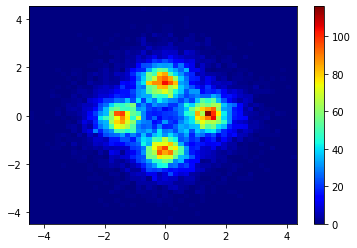

In [47]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [48]:
input_message_length = 4
encoder_output_length = 4
channel_size = 2


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


decoder_input_x = tf.placeholder("float32", [None, input_message_length], name="decoder_input_x")

snr_std = 7.0

input_message_x = Input(shape=(input_message_length,))
# "encoded" is the encoded representation of the input
enc_layer1 = Dense(encoder_output_length, activation='tanh')(input_message_x)
enc_layer2 = Dense(2*channel_size, activation='tanh')(enc_layer1)
enc_layer3 =  enc_layer2 / tf.sqrt(tf.reduce_mean(tf.square(enc_layer2)))
encoder = Model(input_message_x, enc_layer3)

awgn_channel = GaussianNoise(Snr2Sigma(snr_std),input_shape=(2*channel_size,))

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(2*channel_size,))
dec_layer1 = Dense(encoder_output_length, activation='tanh')(encoded_input)
dec_layer2 = Dense(input_message_length, activation='sigmoid')(dec_layer1)
# this model maps an encoded input to its decoder representation
decoder = Model(encoded_input, dec_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))

decoder_output = (tf.nn.sigmoid(decoder_input_x))

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "functional_231"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 4)            20          input_11[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 4)            20          dense_20[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Square_5 (TensorFlo multiple             0           dense_21[0][0]                   
_____________________________________________________________________________________

In [49]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))
print(input_message_length)

[[0 1 1 0]
 [0 0 1 0]
 [1 1 0 1]
 ...
 [0 1 1 0]
 [0 0 1 1]
 [1 1 1 1]]
10000
4


In [50]:
test_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (test_input_message)
print (len(test_input_message))

[[0 1 1 1]
 [1 1 1 0]
 [1 1 1 0]
 ...
 [0 1 1 0]
 [1 0 0 0]
 [0 1 1 0]]
10000


In [51]:
import keras

#def custom_losff_fucntion (act, pred):
#  return (tf.reduce_mean(-1*(act * tf.log(pred) + (1-act)*tf.log(1-pred))))

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
#autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion)
#loss='mean_squared_error'
#for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  snr_std = sigma
  print ("Training for SNR=", snr, " sigma=", sigma) 
  awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
  autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  opt = keras.optimizers.Adam(learning_rate=0.003)
  autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  autoencoder.fit(training_input_message, training_input_message,
                #epochs=50, original
                epochs=25,
                batch_size=500,
                shuffle=False,
                validation_data=(test_input_message, test_input_message))

Training for SNR= 0.0  sigma= 1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/25
10000/10000 [==============================] - 2s 170us/sample - loss: 0.7267 - val_loss: 0.6465
Epoch 2/25
10000/10000 [==============================] - 0s 10us/sample - loss: 0.6681 - val_loss: 0.5898
Epoch 3/25
10000/10000 [==============================] - 0s 11us/sample - loss: 0.6185 - val_loss: 0.5525
Epoch 4/25
10000/10000 [==============================] - 0s 11us/sample - loss: 0.5858 - val_loss: 0.5249
Epoch 5/25
10000/10000 [==============================] - 0s 10us/sample - loss: 0.5625 - val_loss: 0.4933
Epoch 6/25
10000/10000 [==============================] - 0s 10us/sample - loss: 0.5387 - val_loss: 0.4580
Epoch 7/25
10000/10000 [==============================] - 0s 11us/sample - loss: 0.5182 - val_loss: 0.4290
Epoch 8/25
10000/10000 [==============================] - 0s 11us/sample - loss: 0.5028 - val_loss: 0.4081
Epoch 9/25
10000/10000 [==============================] - 0

In [52]:

# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor_4  = numpy.array(())
times_per_iter_dl_tensor_4 = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(channel_size,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [channel_size])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

channel_in = []
channel_out = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    channel_in.append(encoded_message[0])
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print("encoded:",encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    #noised_message = commpy.channels.awgn(encoded_message, snr)
    noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,2*channel_size])
    channel_out.append(noised_message[0]) 
    #noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,channel_size])
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    #print ("decoded1:", decoded_message)
    #decoded_message = train_sess.run ([decoder_output], feed_dict={decoder_input_x:decoded_message})
    #print ("decoded2:", decoded_message)
    #decoded_message = autoencoder.predict(input_message_xx)
    decoded_message = numpy.around(decoded_message[0]).astype(int)
    #print ("decoded3:", decoded_message)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print ("decoded:", decoded_message)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor_4=numpy.append(ber_per_iter_dl_tensor_4 ,ber)
  times_per_iter_dl_tensor_4=numpy.append(times_per_iter_dl_tensor_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 8.86s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 10.34s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 11.81s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 13.15s
SNR: 0.000:
 -> BER: 0.48
 -> Total Time: 44.16s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.32s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.65s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.35s
SNR: 0.500:
 -> BER: 0.46
 -> Total Time: 13.33s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.35s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.71s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 4.04s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 5.43s
SNR: 1.000:
 -> BER: 0.41
 -> Total Time: 13.53s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.33s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 2.65s
SNR: 1.500 - Iter: 750 - Last 250.0

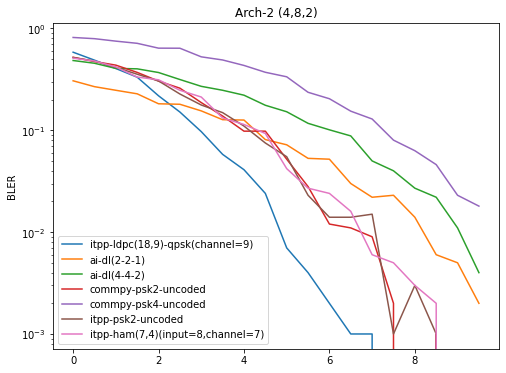

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_2,'', label="ai-dl(2-2-1)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_4,'', label="ai-dl(4-4-2)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

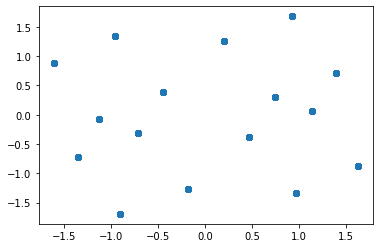

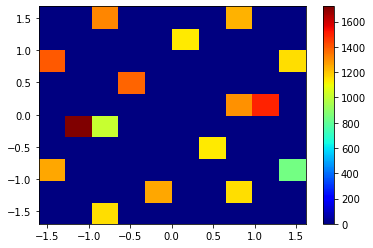

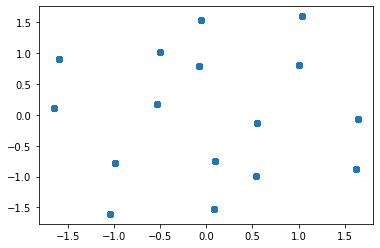

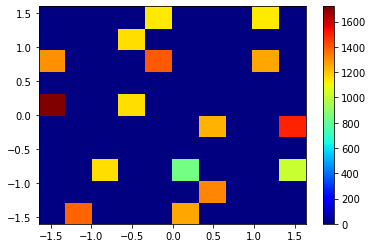

In [54]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

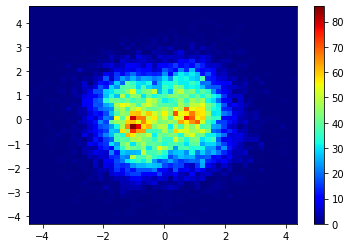

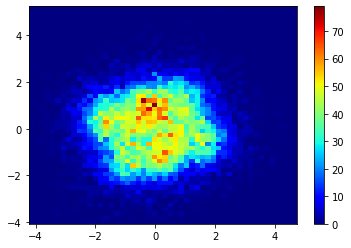

In [55]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [56]:
input_message_length = 8
encoder_output_length = 8
channel_size = 4


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


decoder_input_x = tf.placeholder("float32", [None, input_message_length], name="decoder_input_x")

snr_std = 7.0

input_message_x = Input(shape=(input_message_length,))
# "encoded" is the encoded representation of the input
enc_layer1 = Dense(encoder_output_length, activation='tanh')(input_message_x)
enc_layer2 = Dense(2*channel_size, activation='tanh')(enc_layer1)
enc_layer3 =  enc_layer2 / tf.sqrt(tf.reduce_mean(tf.square(enc_layer2)))
encoder = Model(input_message_x, enc_layer3)

awgn_channel = GaussianNoise(Snr2Sigma(snr_std),input_shape=(2*channel_size,))

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(2*channel_size,))
dec_layer1 = Dense(encoder_output_length, activation='tanh')(encoded_input)
dec_layer2 = Dense(input_message_length, activation='sigmoid')(dec_layer1)
# this model maps an encoded input to its decoder representation
decoder = Model(encoded_input, dec_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))

decoder_output = (tf.nn.sigmoid(decoder_input_x))

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "functional_277"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 8)            72          input_13[0][0]                   
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 8)            72          dense_24[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Square_6 (TensorFlo multiple             0           dense_25[0][0]                   
_____________________________________________________________________________________

In [57]:

training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))
print(input_message_length)

[[1 1 1 ... 1 1 0]
 [0 0 1 ... 0 0 0]
 [1 1 1 ... 0 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 0 ... 0 1 1]
 [1 1 0 ... 0 0 0]]
10000
8


In [58]:
test_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (test_input_message)
print (len(test_input_message))

[[0 1 0 ... 0 1 1]
 [0 0 1 ... 0 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [1 0 0 ... 1 0 1]
 [0 0 1 ... 0 1 1]
 [0 1 1 ... 0 0 1]]
10000


In [59]:
import keras

#def custom_losff_fucntion (act, pred):
#  return (tf.reduce_mean(-1*(act * tf.log(pred) + (1-act)*tf.log(1-pred))))

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
#autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion)
#loss='mean_squared_error'
#for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  snr_std = sigma
  print ("Training for SNR=", snr, " sigma=", sigma) 
  awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
  autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  opt = keras.optimizers.Adam(learning_rate=0.003)
  autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  autoencoder.fit(training_input_message, training_input_message,
                #epochs=50, original
                epochs=25,
                batch_size=500,
                shuffle=False,
                validation_data=(test_input_message, test_input_message))

Training for SNR= 0.0  sigma= 1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/25
10000/10000 [==============================] - 2s 210us/sample - loss: 0.7424 - val_loss: 0.6899
Epoch 2/25
10000/10000 [==============================] - 0s 13us/sample - loss: 0.6902 - val_loss: 0.6417
Epoch 3/25
10000/10000 [==============================] - 0s 12us/sample - loss: 0.6463 - val_loss: 0.5913
Epoch 4/25
10000/10000 [==============================] - 0s 13us/sample - loss: 0.6006 - val_loss: 0.5439
Epoch 5/25
10000/10000 [==============================] - 0s 13us/sample - loss: 0.5692 - val_loss: 0.5066
Epoch 6/25
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5440 - val_loss: 0.4738
Epoch 7/25
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5251 - val_loss: 0.4475
Epoch 8/25
10000/10000 [==============================] - 0s 12us/sample - loss: 0.5108 - val_loss: 0.4249
Epoch 9/25
10000/10000 [==============================] - 0

In [65]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor_8  = numpy.array(())
times_per_iter_dl_tensor_8 = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(channel_size,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [channel_size])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

channel_in = []
channel_out = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    channel_in.append(encoded_message[0])
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print("encoded:",encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    #noised_message = commpy.channels.awgn(encoded_message, snr)
    noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,2*channel_size])
    channel_out.append(noised_message[0]) 
    #noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,channel_size])
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    #print ("decoded1:", decoded_message)
    #decoded_message = train_sess.run ([decoder_output], feed_dict={decoder_input_x:decoded_message})
    #print ("decoded2:", decoded_message)
    #decoded_message = autoencoder.predict(input_message_xx)
    decoded_message = numpy.around(decoded_message[0]).astype(int)
    #print ("decoded3:", decoded_message)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print ("decoded:", decoded_message)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor_8 = numpy.append(ber_per_iter_dl_tensor_8 ,ber)
  times_per_iter_dl_tensor_8 = numpy.append(times_per_iter_dl_tensor_8, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 3.64s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 5.17s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 6.78s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 8.31s
SNR: 0.000:
 -> BER: 0.77
 -> Total Time: 23.90s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.49s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.94s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.46s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.95s
SNR: 0.500:
 -> BER: 0.72
 -> Total Time: 14.84s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.53s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 3.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 4.51s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 5.98s
SNR: 1.000:
 -> BER: 0.69
 -> Total Time: 15.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.50s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 2.97s
SNR: 1.500 - Iter: 750 - Last 250.0 it

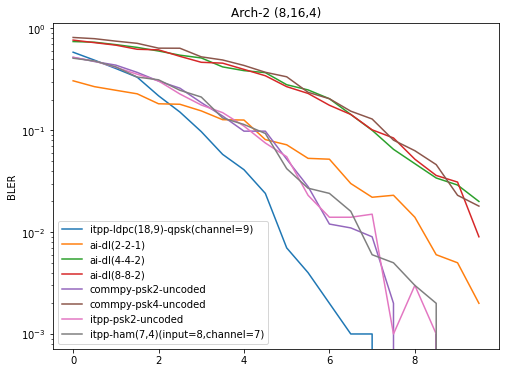

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_2,'', label="ai-dl(2-2-1)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_4,'', label="ai-dl(4-4-2)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_8,'', label="ai-dl(8-8-2)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

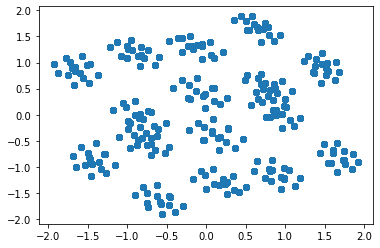

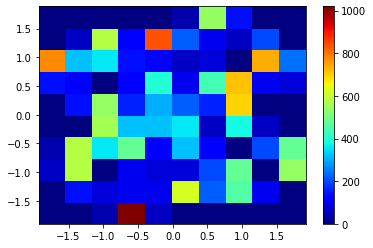

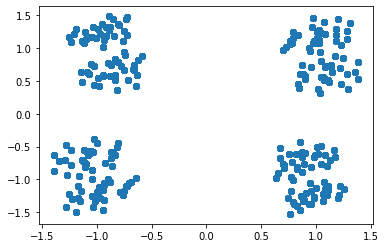

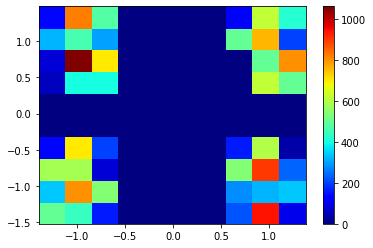

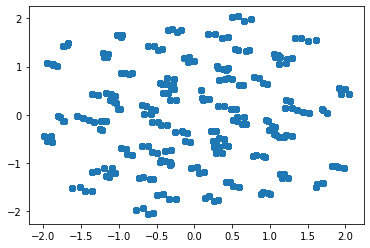

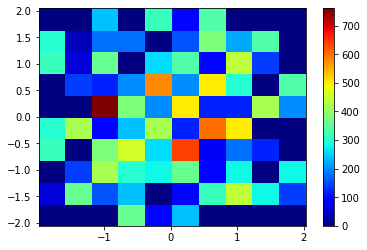

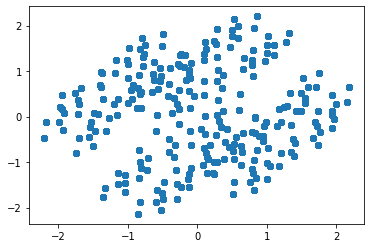

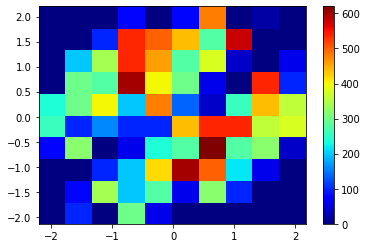

In [62]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

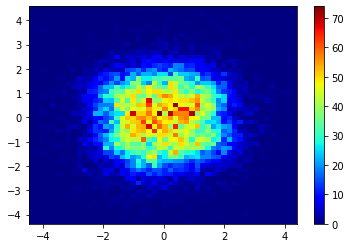

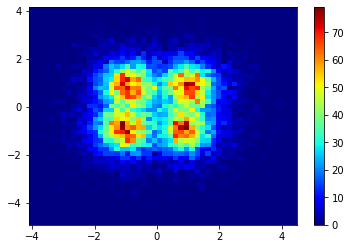

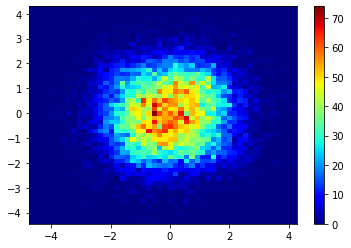

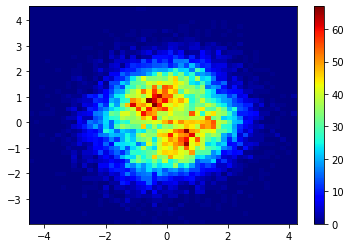

In [63]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [67]:
input_message_length = 16
encoder_output_length = 16
channel_size = 8


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


decoder_input_x = tf.placeholder("float32", [None, input_message_length], name="decoder_input_x")

snr_std = 7.0

input_message_x = Input(shape=(input_message_length,))
# "encoded" is the encoded representation of the input
enc_layer1 = Dense(encoder_output_length, activation='tanh')(input_message_x)
enc_layer2 = Dense(2*channel_size, activation='tanh')(enc_layer1)
enc_layer3 =  enc_layer2 / tf.sqrt(tf.reduce_mean(tf.square(enc_layer2)))
encoder = Model(input_message_x, enc_layer3)

awgn_channel = GaussianNoise(Snr2Sigma(snr_std),input_shape=(2*channel_size,))

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(2*channel_size,))
dec_layer1 = Dense(encoder_output_length, activation='tanh')(encoded_input)
dec_layer2 = Dense(input_message_length, activation='sigmoid')(dec_layer1)
# this model maps an encoded input to its decoder representation
decoder = Model(encoded_input, dec_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))

decoder_output = (tf.nn.sigmoid(decoder_input_x))

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "functional_323"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 16)           272         input_15[0][0]                   
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 16)           272         dense_28[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Square_7 (TensorFlo multiple             0           dense_29[0][0]                   
_____________________________________________________________________________________

In [68]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))
print(input_message_length)

[[0 0 1 ... 1 1 1]
 [1 0 1 ... 1 0 0]
 [1 1 1 ... 0 0 1]
 ...
 [0 1 0 ... 0 1 1]
 [1 0 0 ... 0 1 1]
 [1 0 0 ... 0 1 0]]
10000
16


In [69]:
test_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (test_input_message)
print (len(test_input_message))

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 0 1]
 ...
 [0 0 0 ... 0 1 1]
 [1 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]]
10000


In [70]:

import keras

#def custom_losff_fucntion (act, pred):
#  return (tf.reduce_mean(-1*(act * tf.log(pred) + (1-act)*tf.log(1-pred))))

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
#autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion)
#loss='mean_squared_error'
#for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  snr_std = sigma
  print ("Training for SNR=", snr, " sigma=", sigma) 
  awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
  autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  opt = keras.optimizers.Adam(learning_rate=0.003)
  autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  autoencoder.fit(training_input_message, training_input_message,
                #epochs=50, original
                epochs=25,
                batch_size=500,
                shuffle=False,
                validation_data=(test_input_message, test_input_message))

Training for SNR= 0.0  sigma= 1.0
Train on 10000 samples, validate on 10000 samples
Epoch 1/25
10000/10000 [==============================] - 2s 249us/sample - loss: 0.7020 - val_loss: 0.6151
Epoch 2/25
10000/10000 [==============================] - 0s 16us/sample - loss: 0.6179 - val_loss: 0.5485
Epoch 3/25
10000/10000 [==============================] - 0s 16us/sample - loss: 0.5716 - val_loss: 0.5016
Epoch 4/25
10000/10000 [==============================] - 0s 16us/sample - loss: 0.5418 - val_loss: 0.4675
Epoch 5/25
10000/10000 [==============================] - 0s 17us/sample - loss: 0.5223 - val_loss: 0.4405
Epoch 6/25
10000/10000 [==============================] - 0s 18us/sample - loss: 0.5106 - val_loss: 0.4196
Epoch 7/25
10000/10000 [==============================] - 0s 16us/sample - loss: 0.4991 - val_loss: 0.4014
Epoch 8/25
10000/10000 [==============================] - 0s 16us/sample - loss: 0.4903 - val_loss: 0.3837
Epoch 9/25
10000/10000 [==============================] - 0

In [71]:

# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor_16  = numpy.array(())
times_per_iter_dl_tensor_16 = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(channel_size,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [channel_size])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

channel_in = []
channel_out = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    channel_in.append(encoded_message[0])
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print("encoded:",encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    #noised_message = commpy.channels.awgn(encoded_message, snr)
    noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,2*channel_size])
    channel_out.append(noised_message[0]) 
    #noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,channel_size])
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    #print ("decoded1:", decoded_message)
    #decoded_message = train_sess.run ([decoder_output], feed_dict={decoder_input_x:decoded_message})
    #print ("decoded2:", decoded_message)
    #decoded_message = autoencoder.predict(input_message_xx)
    decoded_message = numpy.around(decoded_message[0]).astype(int)
    #print ("decoded3:", decoded_message)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print ("decoded:", decoded_message)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor_16 = numpy.append(ber_per_iter_dl_tensor_16 ,ber)
  times_per_iter_dl_tensor_16 = numpy.append(times_per_iter_dl_tensor_16, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 11.22s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 12.84s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 14.51s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 16.21s
SNR: 0.000:
 -> BER: 0.95
 -> Total Time: 54.77s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.66s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 3.27s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.91s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 6.62s
SNR: 0.500:
 -> BER: 0.94
 -> Total Time: 16.46s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.60s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 3.22s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 4.89s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 6.50s
SNR: 1.000:
 -> BER: 0.93
 -> Total Time: 16.20s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.65s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 3.27s
SNR: 1.500 - Iter: 750 - Last 250.

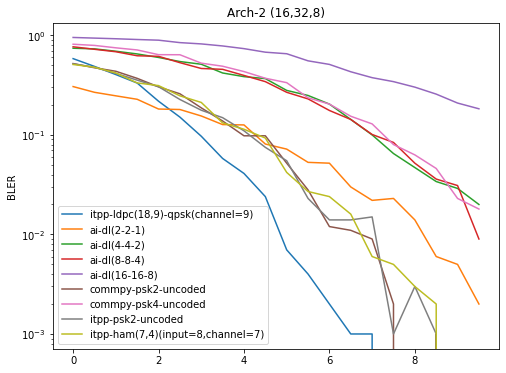

In [72]:

import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_2,'', label="ai-dl(2-2-1)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_4,'', label="ai-dl(4-4-2)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_8,'', label="ai-dl(8-8-4)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_16,'', label="ai-dl(16-16-8)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

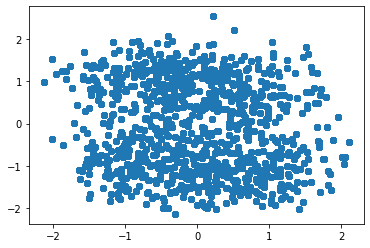

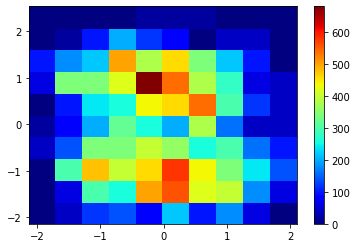

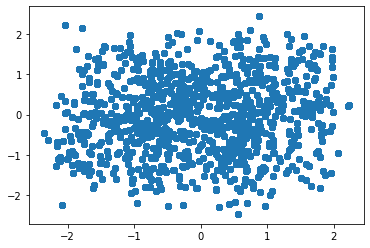

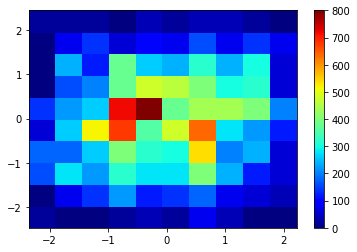

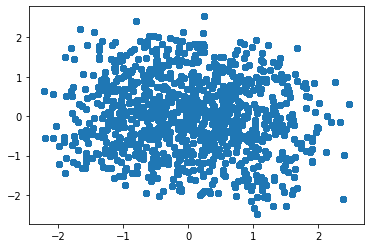

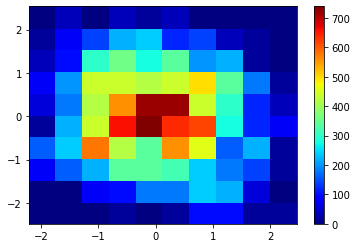

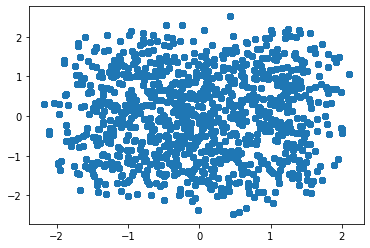

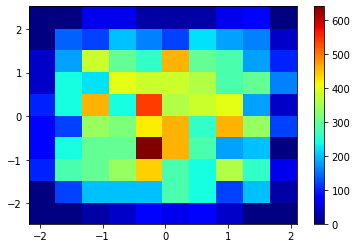

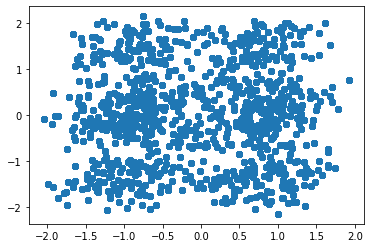

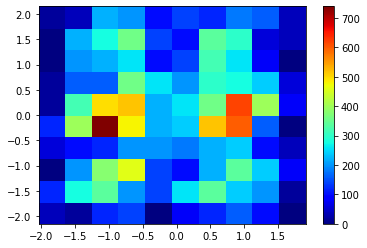

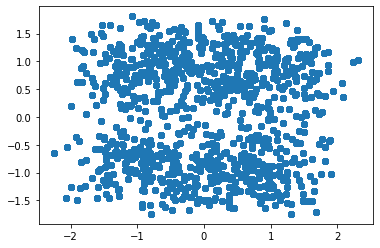

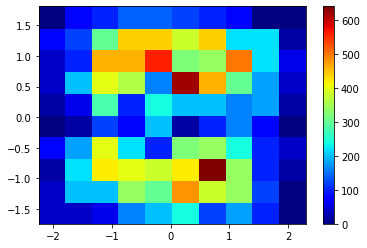

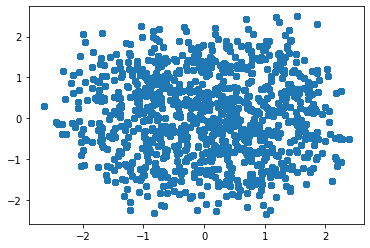

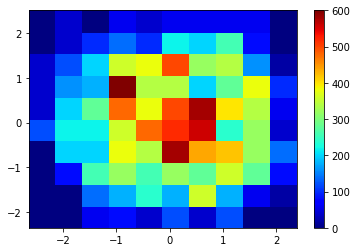

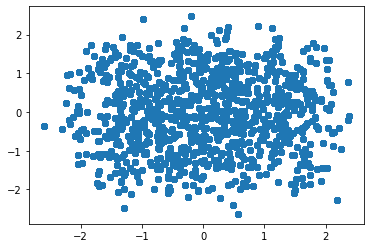

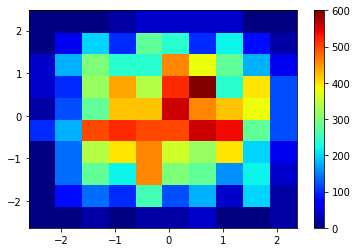

In [73]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

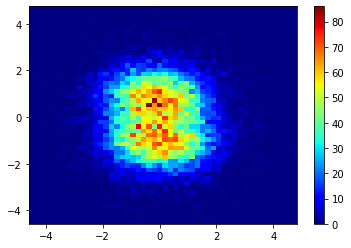

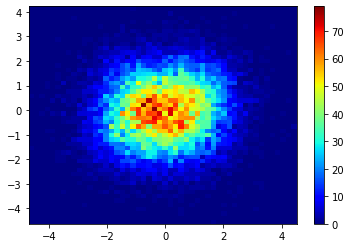

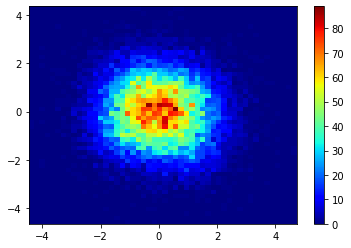

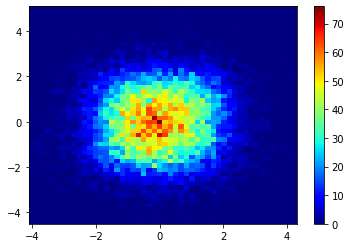

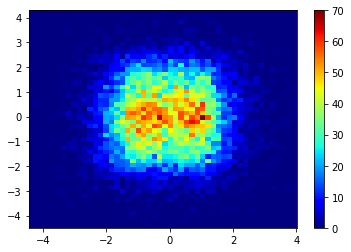

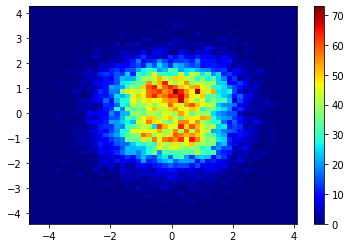

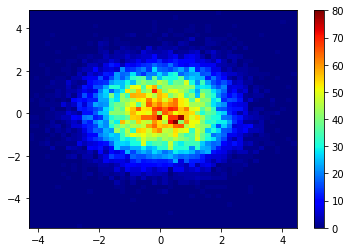

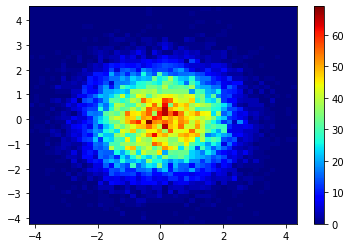

In [74]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()